### Introduction

In this section, the mechanistic model and the machine learning model are combined to a hybrid model. For further information about the
- mechanistic model --> look into section B
- machine learning model --> look into section F
- hybrid model --> look into the README.md file

Here, the hybrid model is applied to batch No. 2. The 500 generated batches based on Batch No. 2 provide the training data for the data-driven random forest, which calculates the glucose concentration based on the biomass and the $CO_2$ concentration all at time step t. The computed glucose concentration is the input to the mechanistic model, which then provides the values for the biomass and the $CO_2$ concentration at time step t+1 as output.

<img src="images\batch_no2_hybrid_structure.png"
     alt="Mechanistic model of one cell (images/MechanisticModel.png)"
     style="float: center"
     width="600" />

### Code

In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from G_model import model_single_timestep_S

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

**Import data**

In [3]:
# Load data
df_batch = pd.read_csv('data/batch_no2/generated data/df_gen.csv')
df_batch.drop(['Unnamed: 0'], axis=1, inplace=True)
df_batch['batch_id'] = df_batch['batch_id'].astype(str).str.zfill(3)
# check of all NaN are removed
df_batch.isna().sum()

time        0
biomass     0
glucose     0
co2         0
batch_id    0
dtype: int64

**Normalization**

In [4]:
df_norm = df_batch.drop(['time', 'batch_id'], axis=1).copy()
mean = df_norm.mean()
std = df_norm.std()
df_norm = (df_norm - mean) / std
df_norm['time'] = df_batch['time']
df_norm['batch_id'] = df_batch['batch_id']

**Splitting the dataset in training and test data**

In [5]:
# group the df by batch_id and take the maximum value of qs
## output is an array (shape: [50,2]) which contains all unique batch_ids and a corresponding max qs
# based on the mean value a binary col is created
## when splitting the data in train & test it is ensured that high and low values of qs are equally distributed
df_grouped = df_norm.groupby('batch_id')['glucose'].max().reset_index()
mean_S = df_grouped['glucose'].mean()
df_grouped['bin'] = df_grouped['glucose'].apply(lambda x: 1 if x > mean_S else 0)

# Split in the list of unique batch_ids into train and test
## I take the batch_ids instead of the whole dataset because otherwise snippets of one batch can be in
## both train and test set
## result is better because it has already seen the data
b_train, b_test = train_test_split(df_grouped, test_size=0.2, stratify=df_grouped['bin'], random_state=42)

In [6]:
b_train = list(b_train['batch_id'].values)
b_test = list(b_test['batch_id'].values)

df_train = df_batch[df_batch['batch_id'].isin(b_train)]
df_test = df_batch[df_batch['batch_id'].isin(b_test)]

# Define X and y
X_train = df_train.copy().drop(['glucose'], axis=1)
y_train = df_train['glucose'].values

X_test = df_test.copy().drop(['glucose'], axis=1)
y_test = df_test[['glucose', 'batch_id']]

**Training ML Model**

In [7]:
model = RandomForestRegressor(n_estimators=50, min_samples_leaf=15 ,random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=15, n_estimators=50, random_state=42)

**Hybrid Model**

In [8]:
batch_ids = X_test['batch_id'].unique()
one_batch = X_test[X_test['batch_id'] == batch_ids[0]]

df_hybrid = pd.DataFrame()

In [9]:
for b in range(len(batch_ids)):
    one_batch = X_test[X_test['batch_id'] == batch_ids[b]]

    # Simulation settings
    t0 = 0
    t_end = 36.8
    delta_t = 2
    dt = delta_t/60
    num_steps = int((t_end - t0) / dt) + 1 # Number of time steps

    time = np.linspace(t0, t_end, num_steps)
    biomass = np.zeros(num_steps)
    substrate_ML = np.zeros(num_steps)
    substrate = np.zeros(num_steps)
    co2 = np.zeros(num_steps)
    volume = np.zeros(num_steps)

    # Extract parameters
    X0 = param['X0_2']
    S0 = param['S0']
    co20 = param['co20']
    V0 = param['V0_2']

    # Set initial values
    biomass[0] = X0
    substrate[0] = S0
    substrate_ML[0] = S0
    co2[0] = co20
    volume[0] = V0
    
    for i in range(1, num_steps):
        # calculating qs    
        input = one_batch.iloc[[i]]
        c_glucose = model.predict(input)

        # previous values
        c_biomass = biomass[i-1]
        c_co2 = co2[i-1]
        vol = volume[i-1]

        # new values from model
        substrate_ML[i] = c_glucose
        biomass[i], substrate[i], co2[i], volume[i] = model_single_timestep_S(i, c_glucose, c_biomass, c_co2, vol)
    
    one_batch['glucose'] = y_test.loc[y_test['batch_id'] == batch_ids[b], 'glucose']
    one_batch['glucose_ML'] = substrate
    one_batch['biomass_sim'] = biomass
    one_batch['co2_sim'] = co2
    one_batch['volume_sim'] = volume

    df_hybrid = pd.concat([df_hybrid, one_batch])

**Data Visualization of one batch**

In [10]:
batch_ids_hybrid = df_hybrid['batch_id'].unique()
batch_ids_hybrid[:10]

array(['006', '012', '013', '020', '021', '032', '036', '037', '051',
       '053'], dtype=object)

In [19]:
one_batch_hybrid = df_hybrid[df_hybrid['batch_id'] == '021']

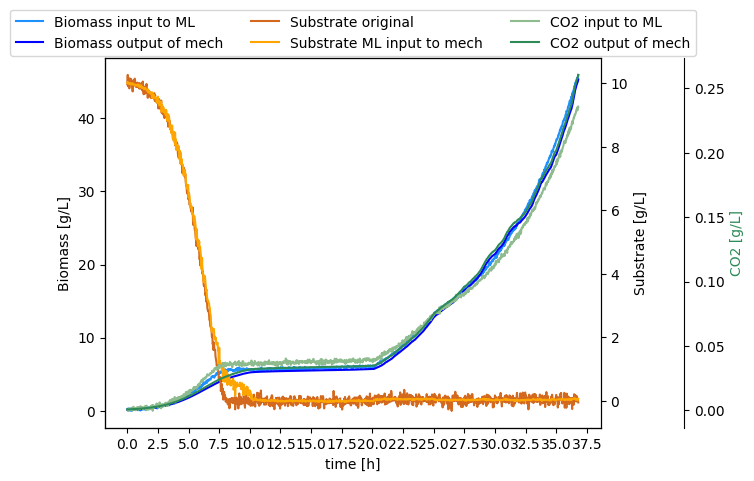

In [20]:
fig, ax = plt.subplots()
ax_2nd = ax.twinx()
ax_3rd = ax.twinx()

ax.plot(one_batch_hybrid['time'], one_batch_hybrid['biomass'], label='Biomass input to ML', color='dodgerblue')
ax.plot(one_batch_hybrid['time'], one_batch_hybrid['biomass_sim'], label='Biomass output of mech', color='blue')

ax_2nd.plot(one_batch_hybrid['time'], one_batch_hybrid['glucose'], label='Substrate original', color='chocolate')
ax_2nd.plot(one_batch_hybrid['time'], one_batch_hybrid['glucose_ML'], label='Substrate ML input to mech', color='orange')

ax_3rd.plot(one_batch_hybrid['time'], one_batch_hybrid['co2'], label='CO2 input to ML', color='darkseagreen')
ax_3rd.plot(one_batch_hybrid['time'], one_batch_hybrid['co2_sim'], label='CO2 output of mech', color='seagreen')
#ax_3rd.plot(one_batch_hybrid['time'], one_batch_hybrid['volume_sim'], label='volume_sim', color='green')
ax.locator_params(axis='x', nbins=20)

ax.set_xlabel('time [h]')
ax.set_ylabel('Biomass [g/L]')
ax_2nd.set_ylabel('Substrate [g/L]')
ax_3rd.set_ylabel('CO2 [g/L]', color='seagreen')

ax_3rd.spines['right'].set_position(('outward', 60))

handles, labels = ax.get_legend_handles_labels()
handles_2nd, labels_2nd = ax_2nd.get_legend_handles_labels()
handles_3rd, labels_3rd = ax_3rd.get_legend_handles_labels()
all_handles = handles + handles_2nd + handles_3rd
all_labels = labels + labels_2nd + labels_3rd

# Create a single legend using the combined handles and labels
ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)